In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import math
import os

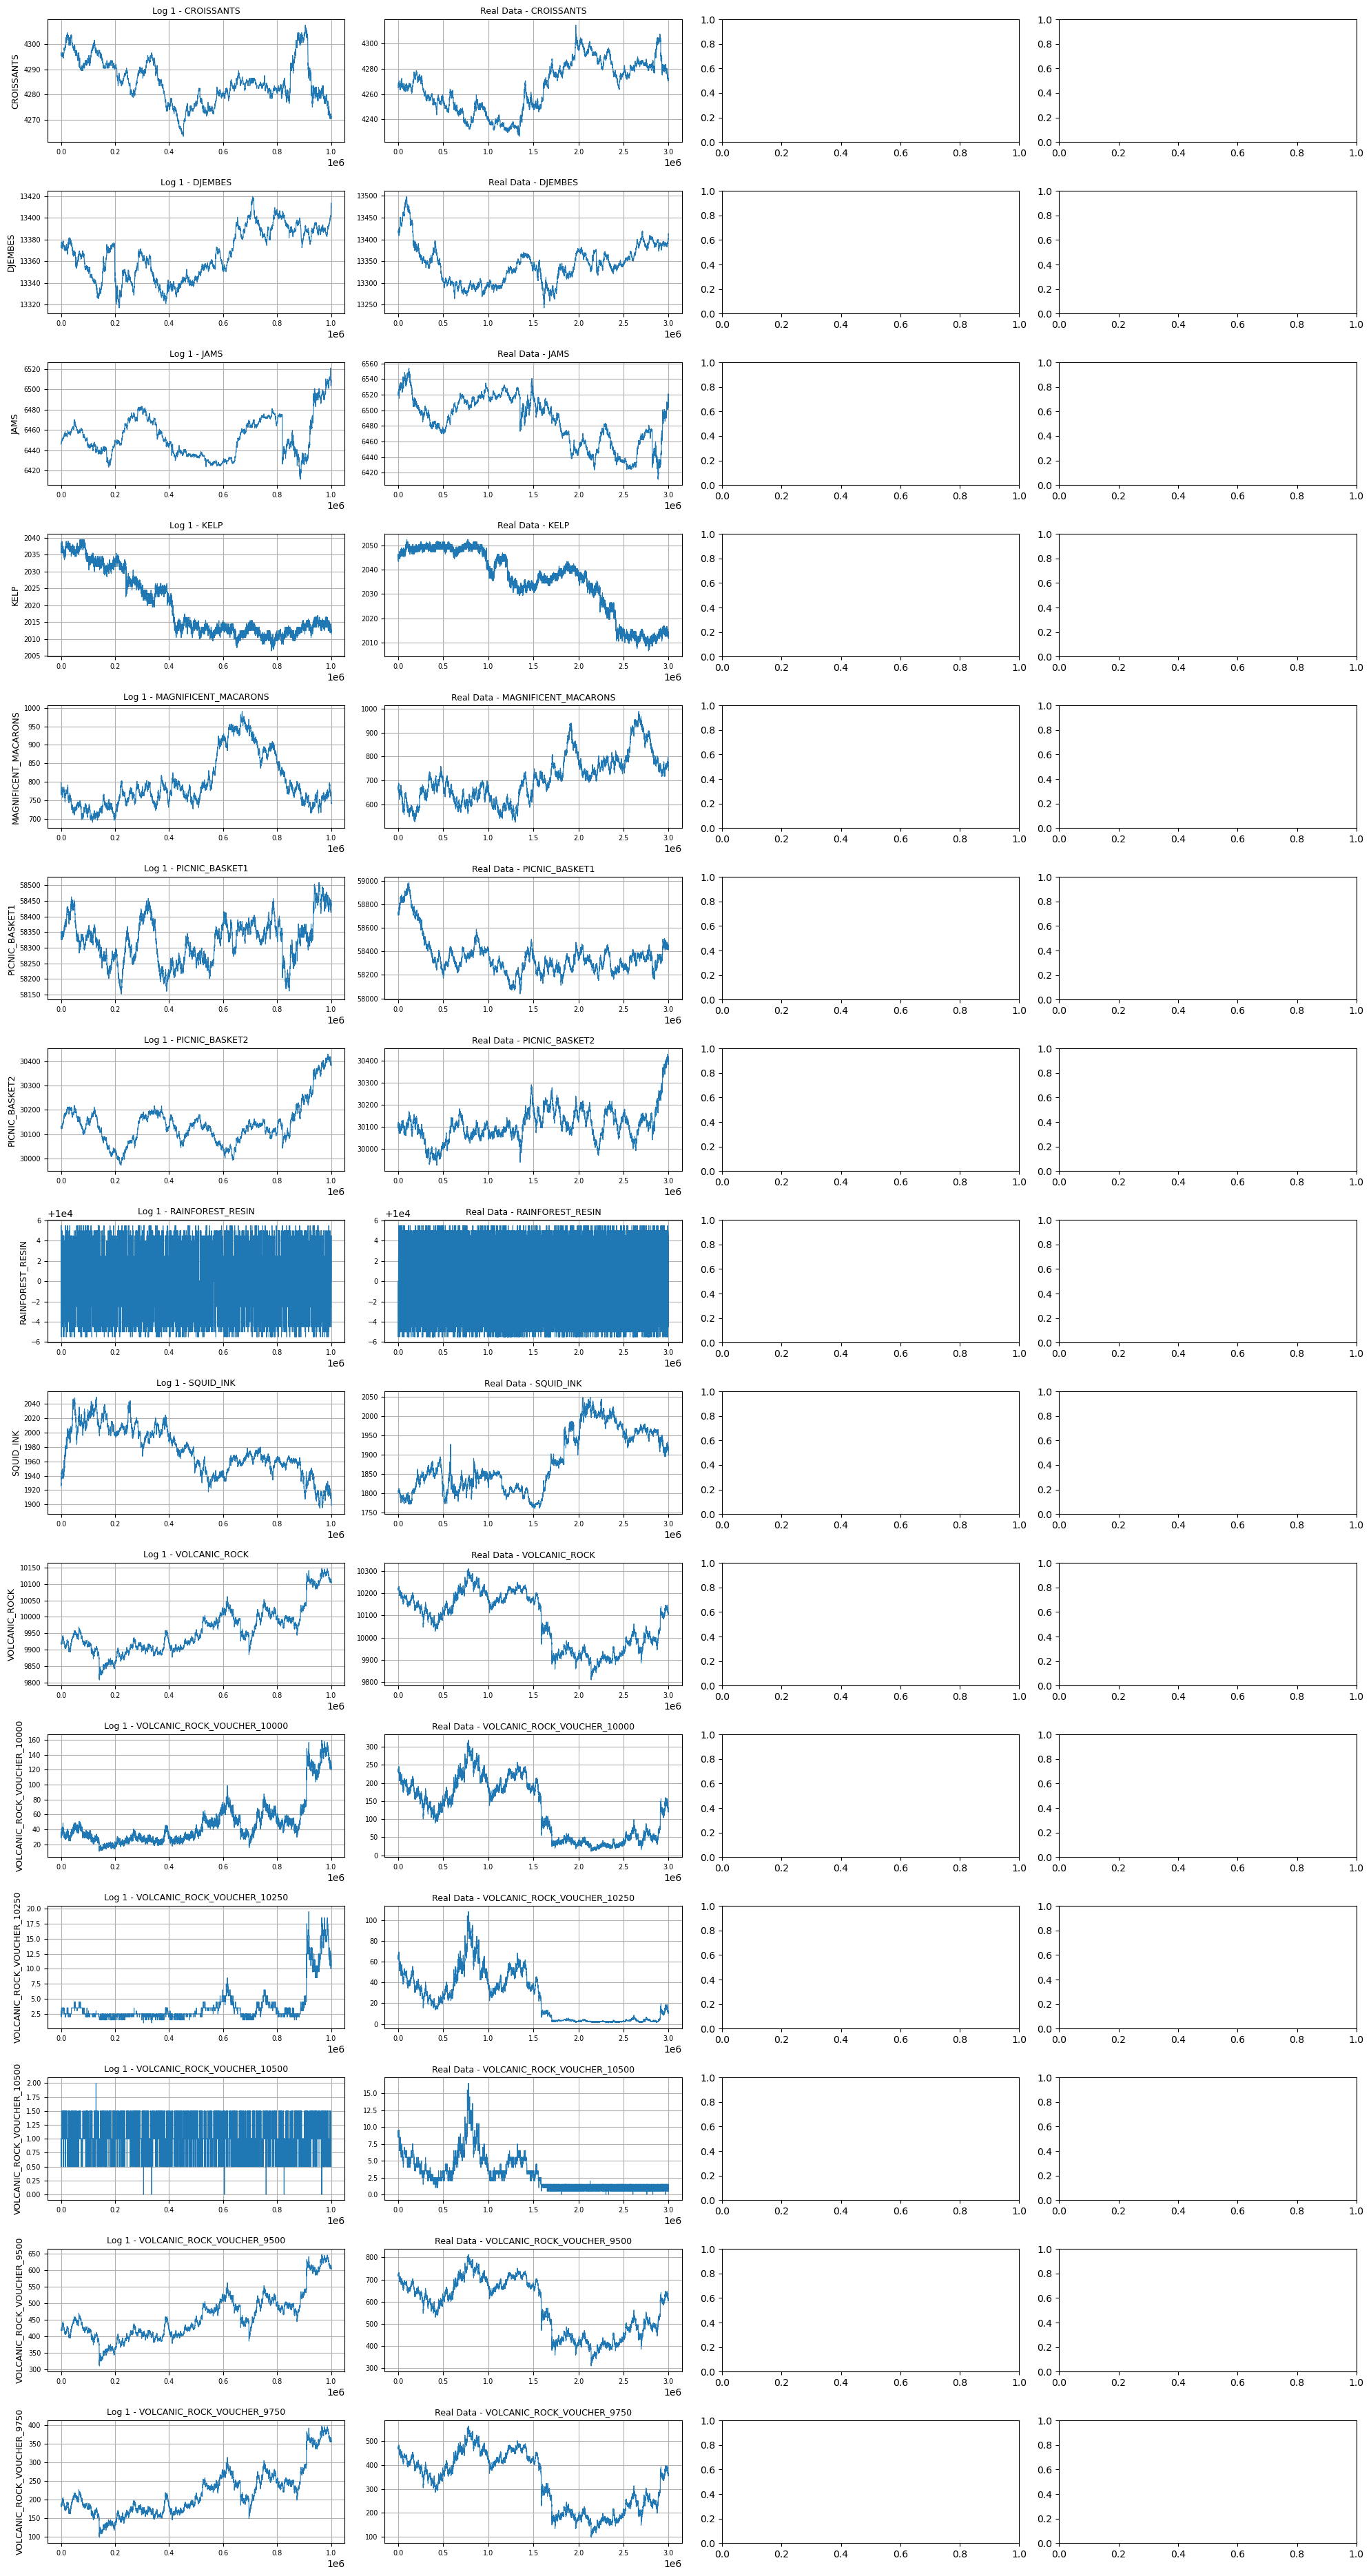

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import math

# Load round 4 data (3 days) and align timestamps
price_data = [pd.read_csv(f'/Users/tommasomarrucci/Desktop/IMC /IMC BIEF 42/data/round_5/prices_round_5_day_{i}.csv', sep=';') for i in range(2,5)]
for i in range(1, 3):
    price_data[i]['timestamp'] += price_data[i-1]['timestamp'].iloc[-1]

data_df = pd.concat(price_data).reset_index(drop=True)

# Pivot real data (round 4) mid-prices
real_pivot = data_df.pivot_table(index='timestamp', columns='product', values='mid_price', aggfunc='mean')

# Process the 3 log files
log_files = [
    '/Users/tommasomarrucci/Desktop/IMC /IMC BIEF 42/1.log'
]

def extract_activities_log(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    start_marker = "Activities log:"
    header = None
    data_lines = []
    in_section = False
    for line in lines:
        if start_marker in line:
            in_section = True
            continue
        if in_section:
            if line.strip() == "" or line.strip().startswith("{"):
                break
            if header is None:
                header = line.strip()
            else:
                data_lines.append(line.strip())

    csv_text = "\n".join([header] + data_lines)
    return pd.read_csv(StringIO(csv_text), sep=';')

# Collect all mid_price pivots
pivot_dict = {}
all_products = set()

for i, file_path in enumerate(log_files, start=1):
    df = extract_activities_log(file_path)
    pivot = df.pivot(index='timestamp', columns='product', values='mid_price')
    pivot_dict[i] = pivot
    all_products.update(pivot.columns)

# Add real data as "log 4"
pivot_dict[4] = real_pivot
all_products.update(real_pivot.columns)

# Plotting
all_products = sorted(all_products)
n_rows = len(all_products)
n_cols = 4  # 3 logs + 1 real data column

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 2.5 * n_rows), sharex=False)
if n_rows == 1:
    axes = [axes]
if n_cols == 1:
    axes = [[ax] for ax in axes]

for row_idx, product in enumerate(all_products):
    for col_idx, log_id in enumerate(sorted(pivot_dict.keys())):
        ax = axes[row_idx][col_idx]
        pivot = pivot_dict[log_id]
        if product in pivot.columns:
            ax.plot(pivot.index, pivot[product], linewidth=0.8)
        title = f"Log {log_id}" if log_id <= 3 else "Real Data"
        ax.set_title(f"{title} - {product}", fontsize=9)
        ax.tick_params(axis='both', labelsize=7)
        ax.grid(True)

# Add product labels on the left
for row_idx, product in enumerate(all_products):
    axes[row_idx][0].set_ylabel(product, fontsize=9)

plt.tight_layout()
plt.show()

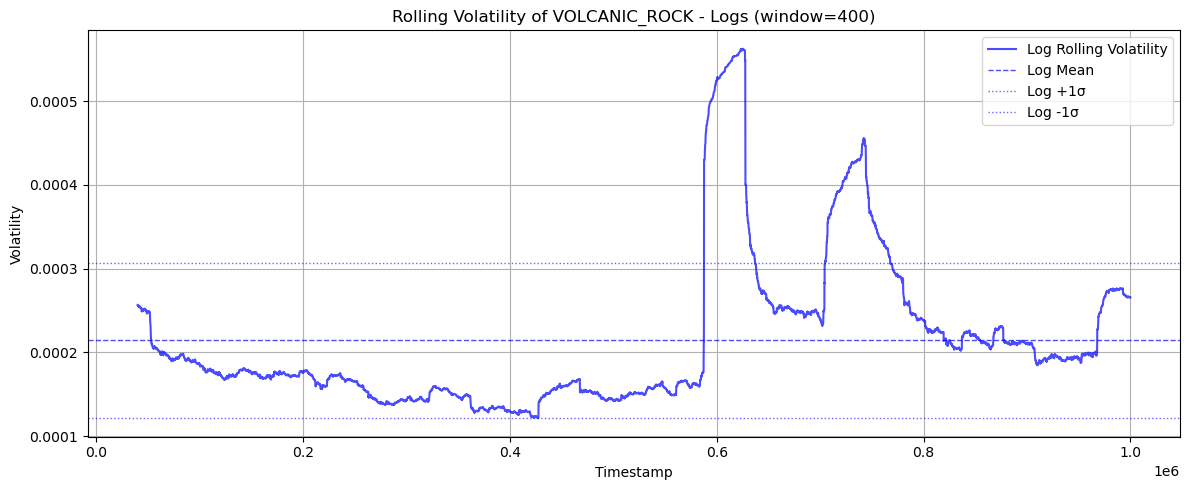

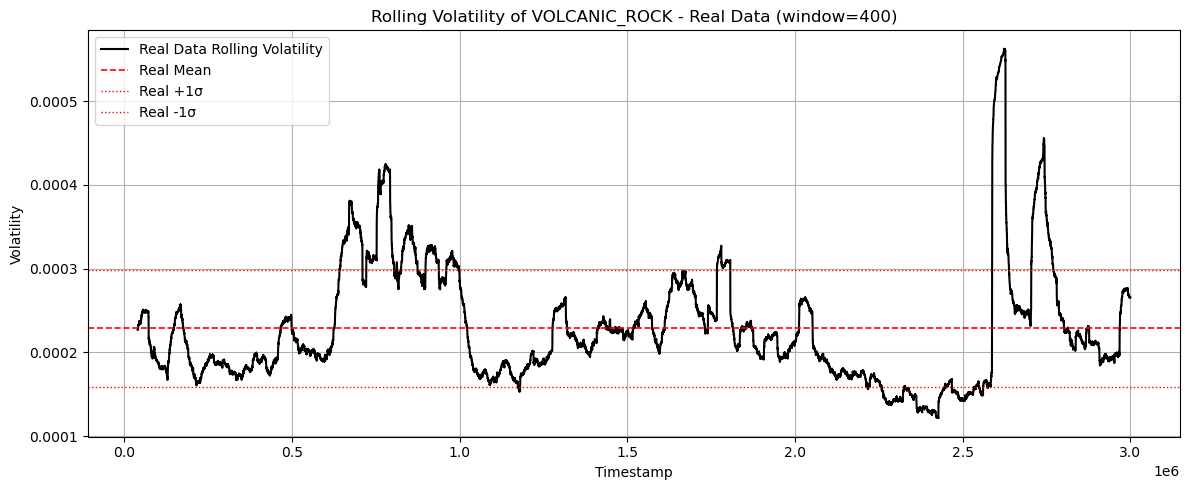

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# === Parameters ===
window_size = 400

# === Load and align real price data ===
price_data = [pd.read_csv(f'/Users/tommasomarrucci/Desktop/IMC BIEF 42/data/round_4/prices_round_4_day_{i}.csv', sep=';') for i in range(1, 4)]
for i in range(1, 3):
    price_data[i]['timestamp'] += price_data[i-1]['timestamp'].iloc[-1]
real_df = pd.concat(price_data).reset_index(drop=True)
real_df = real_df[real_df['product'] == 'VOLCANIC_ROCK'].copy()
real_df.set_index('timestamp', inplace=True)

real_returns = real_df['mid_price'].pct_change().dropna()
real_rolling_vol = real_returns.rolling(window=window_size).std()
real_mean = real_rolling_vol.mean()
real_std = real_rolling_vol.std()

# === Function to extract Activities log ===
def extract_activities_log(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    start_marker = "Activities log:"
    header = None
    data_lines = []
    in_section = False
    for line in lines:
        if start_marker in line:
            in_section = True
            continue
        if in_section:
            if line.strip() == "" or line.strip().startswith("{"):
                break
            if header is None:
                header = line.strip()
            else:
                data_lines.append(line.strip())

    csv_text = "\n".join([header] + data_lines)
    return pd.read_csv(StringIO(csv_text), sep=';')

# === Load and process log data ===
log_paths = {
    'Log 1': '/Users/tommasomarrucci/Desktop/IMC BIEF 42/1.log',
    'Log 2': '/Users/tommasomarrucci/Desktop/IMC BIEF 42/2.log',
    'Log 3': '/Users/tommasomarrucci/Desktop/IMC BIEF 42/3.log',
}

log_rolling_vols = {}
log_means = {}
log_stds = {}

for label, path in log_paths.items():
    df = extract_activities_log(path)
    df = df[df['product'] == 'VOLCANIC_ROCK'].copy()
    df.set_index('timestamp', inplace=True)
    returns = df['mid_price'].pct_change().dropna()
    rolling_vol = returns.rolling(window=window_size).std()
    log_rolling_vols[label] = rolling_vol
    log_means[label] = rolling_vol.mean()
    log_stds[label] = rolling_vol.std()

# === Plot 1: LOG FILES ===
# === Plot 1: LOG FILES (simplified legend) ===
plt.figure(figsize=(12, 5))

# Only add label once for the main line and the stats
plotted_main = False
plotted_mean = False
plotted_sigma = False

for label, series in log_rolling_vols.items():
    plt.plot(series.index, series, color='blue', alpha=0.7, label='Log Rolling Volatility' if not plotted_main else None)
    plt.axhline(log_means[label], linestyle='--', color='blue', alpha=0.7, linewidth=1, label='Log Mean' if not plotted_mean else None)
    plt.axhline(log_means[label] + log_stds[label], linestyle=':', color='blue', alpha=0.6, linewidth=1, label='Log +1σ' if not plotted_sigma else None)
    plt.axhline(log_means[label] - log_stds[label], linestyle=':', color='blue', alpha=0.6, linewidth=1, label='Log -1σ' if not plotted_sigma else None)

    plotted_main = plotted_mean = plotted_sigma = True

plt.title(f'Rolling Volatility of VOLCANIC_ROCK - Logs (window={window_size})')
plt.xlabel('Timestamp')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: REAL DATA ===
plt.figure(figsize=(12, 5))
plt.plot(real_rolling_vol.index, real_rolling_vol, label='Real Data Rolling Volatility', color='black')
plt.axhline(real_mean, linestyle='--', color='red', linewidth=1.2, label='Real Mean')
plt.axhline(real_mean + real_std, linestyle=':', color='red', linewidth=1, label='Real +1σ')
plt.axhline(real_mean - real_std, linestyle=':', color='red', linewidth=1, label='Real -1σ')

plt.title(f'Rolling Volatility of VOLCANIC_ROCK - Real Data (window={window_size})')
plt.xlabel('Timestamp')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()